In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import sys

sys.path.append('.')

import hark_portfolio_agents as hpa

In [3]:
sys.path.append('../PNL/py')

import util as UTIL
import pnl as pnl

## How to use this code


### Initialize the agents to start

This is to set up the agent parameters and quantities used in the simulation.

In [4]:
## List of tuples: 
##  ( parameters, (i.e. coefficient of relative risk aversion CRRA)
##    number of agents represented,
##    ( initial risky percent, $$$ in risky asset, $$$ in riskless asset)
agent_classes = [
    ({'CRRA': 5.0}, 100, 10), # Normal consumers
    ({'CRRA': 6.0}, 50,  10),  # More risk-averse consumers
    ({'CRRA': 4.0}, 50,  10)  #  Less risk-averse consumers
]


### parameters shared by all agents
ap = {
    'AdjustPrb' : 1.0, # probabability of rebalancing during simulation
    'aNrmInitStd' : 0.0,
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0
}

In [5]:
agents = hpa.create_agents(agent_classes, ap)

In [6]:
agents[0].state_now["mNrm"]

array([21758.4000674 , 21758.4000674 , 22575.01392839, 24453.49999542,
       20838.78035494, 21758.4000674 , 24453.49999542, 21758.4000674 ,
       20838.78035494, 23421.90672017, 23421.90672017, 22575.01392839,
       20838.78035494, 22575.01392839, 20838.78035494, 23421.90672017,
       22575.01392839, 24453.49999542, 26414.26059461, 23421.90672017,
       26414.26059461, 24453.49999542, 23421.90672017, 20838.78035494,
       26414.26059461, 19258.98586554, 19258.98586554, 19258.98586554,
       24453.49999542, 22575.01392839, 19258.98586554, 24453.49999542,
       19258.98586554, 21758.4000674 , 21758.4000674 , 23421.90672017,
       23421.90672017, 23421.90672017, 20838.78035494, 21758.4000674 ,
       24453.49999542, 26414.26059461, 20838.78035494, 21758.4000674 ,
       23421.90672017, 21758.4000674 , 19258.98586554, 23421.90672017,
       22575.01392839, 20838.78035494, 21758.4000674 , 26414.26059461,
       21758.4000674 , 24453.49999542, 19258.98586554, 19258.98586554,
      

In [7]:
agents[0].state_now["pLvl"]

array([2.83445475, 2.83445475, 2.73191849, 2.52204748, 2.95954583,
       2.83445475, 2.52204748, 2.83445475, 2.95954583, 2.63313315,
       2.63313315, 2.73191849, 2.95954583, 2.73191849, 2.95954583,
       2.63313315, 2.73191849, 2.52204748, 2.33482594, 2.63313315,
       2.33482594, 2.52204748, 2.63313315, 2.95954583, 2.33482594,
       3.20232689, 3.20232689, 3.20232689, 2.52204748, 2.73191849,
       3.20232689, 2.52204748, 3.20232689, 2.83445475, 2.83445475,
       2.63313315, 2.63313315, 2.63313315, 2.95954583, 2.83445475,
       2.52204748, 2.33482594, 2.95954583, 2.83445475, 2.63313315,
       2.83445475, 3.20232689, 2.63313315, 2.73191849, 2.95954583,
       2.83445475, 2.33482594, 2.83445475, 2.52204748, 3.20232689,
       3.20232689, 2.73191849, 2.83445475, 2.73191849, 2.33482594,
       2.63313315, 2.52204748, 2.73191849, 2.83445475, 2.33482594,
       2.83445475, 2.83445475, 2.63313315, 2.83445475, 2.52204748,
       2.52204748, 2.63313315, 2.33482594, 2.73191849, 2.33482

#### Test agent

This is a test agent used to test and demonstrate the functions below.

In [8]:
# test agent
agent = cpm.PortfolioConsumerType(
    AgentCount = 3,
    **ap
)
agent.solve()
agent.T_sim = 100
agent.track_vars += ['pLvl','mNrm','Share','Risky']
agent.initialize_sim()
agent.simulate()

{'pLvl': array([[2.83445475, 3.20232689, 3.20232689],
        [2.43461086, 2.75058892, 3.33918675],
        [2.25885489, 2.33482594, 3.35593827],
        [2.45934196, 2.75058892, 3.25081536],
        [2.56444841, 2.66442825, 3.82968878],
        [2.67404685, 2.67779474, 4.16959689],
        [2.78832928, 2.5939143 , 4.03898658],
        [3.03581041, 2.40665811, 3.91246756],
        [3.57639786, 2.41873147, 3.93209502],
        [3.59433938, 2.84943553, 3.37741192],
        [3.74795293, 2.64373312, 3.27161636],
        [3.21924593, 2.87838047, 3.16913479],
        [2.76512127, 2.78821679, 3.45041472],
        [2.77899291, 2.70087744, 3.59787727],
        [3.02564538, 2.81630654, 3.33814441],
        [3.56442274, 2.41902274, 3.3548907 ],
        [3.06160553, 2.077782  , 3.11269919],
        [3.07696452, 2.44777311, 2.88799162],
        [3.62488029, 2.55238513, 3.14431839],
        [3.36319807, 2.36812696, 3.27869911],
        [3.25784775, 2.57831259, 3.29514718],
        [3.83797344, 2.392

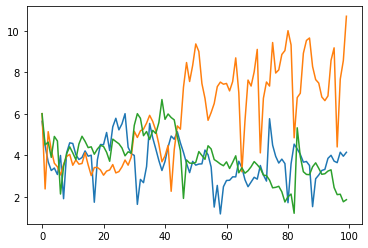

In [9]:
### This is not working for some reason!

plt.plot(agent.history['mNrm'] * agent.history['pLvl'])

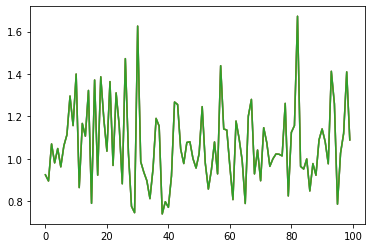

In [10]:
plt.plot(agent.history['Risky'])

The normalize market assets of each agent at the current (final) stage of the simulation.

The function from normalized market assets to the proportion of assets allocated to the risky share.

### Synthetic price data

In the future, get this from the LiquidityModel.

For now, just use any array of prices with noise and drift.

In [11]:
## This is a dummy method that the ABM group
## needs to write to connect to the NetLogo
## model.

def run_market(buy_sell, asset_price):
    config = UTIL.read_config(config_file="../PNL/macroliquidity.ini")
    pnl.run_NLsims(
        config,
        # just simply rounding here to get number of shares from dollar buy/sell amounts
        broker_buy_limit = round(buy_sell[0] / asset_price),
        broker_sell_limit = round(buy_sell[1] / asset_price))
    
def get_transactions():
    # use run_market() first to create logs
    transactions = pd.read_csv("../PNL/out/logs/LMtransactions_0.csv", delimiter='\t')
    return transactions

### Agents estimate return rate and volatility from historical data

The agents look at the most recent historical price data to form their expectations of the future.

This is a very simplified version of what could later be better specified in line with _adaptive expectations_:

https://en.wikipedia.org/wiki/Adaptive_expectations

### Demand function for the intermittent demand problem

In the intermittent demand problem, consumers take their current state and determine risky porfolio share of their assets to invest.

The agent responds to the price history by:
 - updating their current assets
 - updating their expectations of the risky asset
 - returning their risky share allocation.

Other aspects of the problem are fixed for now.

### Putting it all together

Each agent knows their old risky allocation, old risk free allocation, and the prices of the last quarter.

They computer their new market assets and then their new demand.

In [12]:
# STEP 1. Initialize the agents. (and the market?)

## List of tuples: 
##  ( parameters, (i.e. coefficient of relative risk aversion CRRA)
##    number of agents represented,
##    initial assets
agent_classes = [
    ({'CRRA': 5.0}, 100, 10), # Normal consumers
    ({'CRRA': 6.0}, 50,  10),  # More risk-averse consumers
    ({'CRRA': 4.0}, 50,  10)  #  Less risk-averse consumers
]


### parameters shared by all agents
ap = {
    'aNrmInitStd' : 0.0,
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0
}


agents = hpa.create_agents(agent_classes, ap)

In [13]:
# STEP 2. Create starting demand for the market.
#         Burn in the new prices.

# The initial demands for each agent
# hpa.init_prices is used to set the agent's starting
# beliefs about the price process.
init_demands = hpa.demands(agents, hpa.init_prices)

buy_sell = hpa.aggregate_buy_and_sell(
    hpa.no_demand(agents), # zero allocated to risky asset
    init_demands
)


Getting risky asset demand for all agents
computing aggregate buy/sell transactions


In [14]:
# STEP 3: Create the starting asset price. This will be used
#         to translate $$$ values to asset quantities
#         and adjust each period.

asset_price = 100

print(f"Initial Buy/Sell: {buy_sell}")

## TODO: ABM Group reimplement the run_market method
transactions = get_transactions()
print(hpa.risky_expectations(transactions))

Initial Buy/Sell: (69354.0650814572, 0)
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}


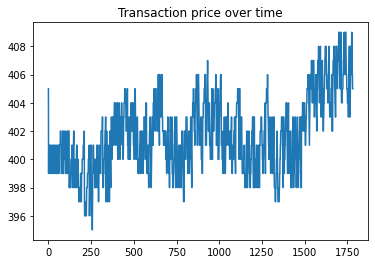

In [15]:
plt.plot(transactions['TrdPrice'])
plt.title("Transaction price over time")
plt.show()


old_demands = init_demands

Asset price: 100
simulating macro agents
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}
Getting risky asset demand for all agents
computing aggregate buy/sell transactions
Round 0 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}


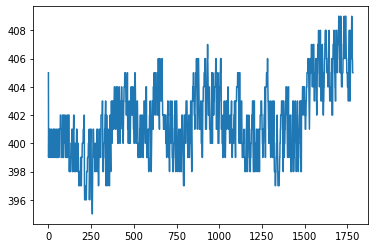

Asset price: 99.22018706765978
simulating macro agents
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}
Getting risky asset demand for all agents
computing aggregate buy/sell transactions
Round 1 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}


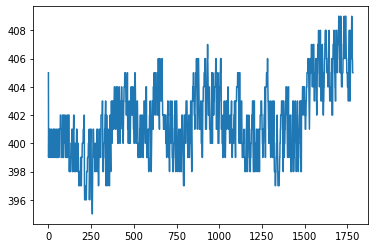

Asset price: 98.44645521741401
simulating macro agents
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}
Getting risky asset demand for all agents
computing aggregate buy/sell transactions
Round 2 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}


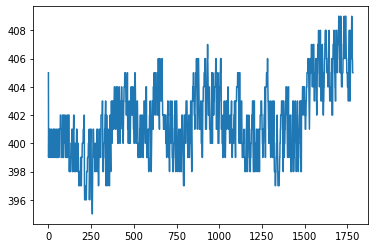

Asset price: 97.67875702819809
simulating macro agents
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}
Getting risky asset demand for all agents
computing aggregate buy/sell transactions
Round 3 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}


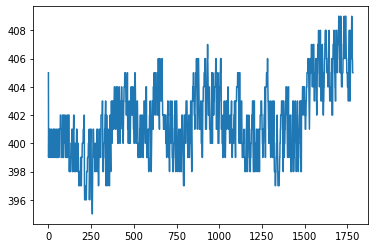

Asset price: 96.91704544874302
simulating macro agents
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}
Getting risky asset demand for all agents
computing aggregate buy/sell transactions
Round 4 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}


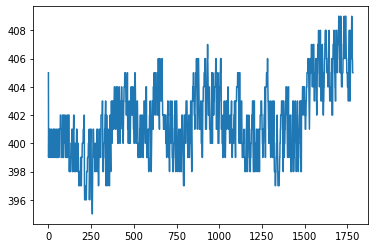

Asset price: 96.16127379469168
simulating macro agents
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}
Getting risky asset demand for all agents
computing aggregate buy/sell transactions
Round 5 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}


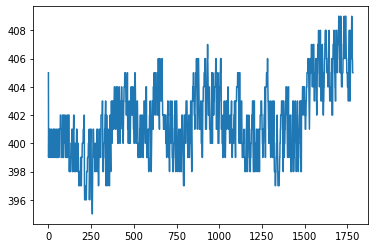

Asset price: 95.4113957457376
simulating macro agents
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}
Getting risky asset demand for all agents
computing aggregate buy/sell transactions
Round 6 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}


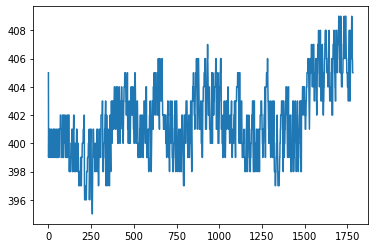

Asset price: 94.66736534278603
simulating macro agents
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}
Getting risky asset demand for all agents
computing aggregate buy/sell transactions
Round 7 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}


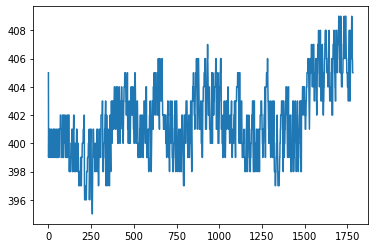

Asset price: 93.92913698513722
simulating macro agents
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}
Getting risky asset demand for all agents
computing aggregate buy/sell transactions
Round 8 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}


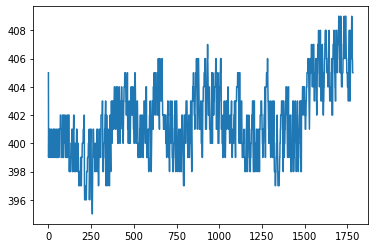

Asset price: 93.19666542769156
simulating macro agents
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}
Getting risky asset demand for all agents
computing aggregate buy/sell transactions
Round 9 Buy/Sell: (0, 0.0)
{'RiskyAvg': 0.9922018706765978, 'RiskyStd': 2.6465045554713837}


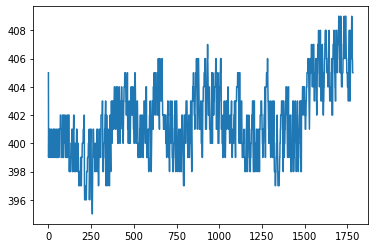

In [17]:
# STEP 4. Run simulation for N rebalances

N = 10

for i in range(N):
    
    print(f"Asset price: {asset_price}")

    # simulate one period on the macro side
    hpa.simulate(agents, 1)
    
    hpa.update_agents(agents, transactions)
    print(hpa.risky_expectations(transactions))
    new_demands = hpa.demands(agents, transactions)
    
    buy_sell = hpa.aggregate_buy_and_sell(
        old_demands,
        new_demands
    )
    print(f"Round {i} Buy/Sell: {buy_sell}")

    #run_market(buy_sell, asset_price)
    transactions = get_transactions()
    print(hpa.risky_expectations(transactions))
    
    plt.plot(transactions['TrdPrice'])
    plt.show()
    
    old_demands = new_demands
    
    risky_return = hpa.risky_actual_return(transactions)
    asset_price = asset_price * risky_return[0]

In [ ]:
agents[0].history['Risky'][:,0]

In [ ]:
plt.plot(transactions[transactions['OrderQuantity'] > 0]['OrderPrice'])

In [ ]:
transactions['OrderQuantity'] > 0

In [ ]:
transactions

In [ ]:
buys = transactions[(transactions['OrderBA'] == "Buy") & (transactions['OrderQuantity'] > 0)]
sells = transactions[(transactions['OrderBA'] == "Sell") & (transactions['OrderQuantity'] > 0)]


plt.plot(buys['Tick'], buys['OrderPrice'])
plt.plot(sells['Tick'], sells['OrderPrice'])


In [ ]:
sells

In [ ]:
(transactions['OrderPrice'] * transactions['OrderQuantity']).sum() / transactions['OrderQuantity'].sum()

In [ ]:
hpa.risky_expectations(transactions)

In [ ]:
transactions[(transactions['OrderBA'] == "Buy") & (transactions['OrderQuantity'] > 0)]

In [ ]:
agents[0].solution[0].ShareFuncAdj(0)

In [ ]:
agents[0].state_now['mNrm']

In [ ]:
agents[0].state_now['pLvl']

In [ ]:
new_assets(agent, hpa.risky_share, prices)

In [ ]:
transactions = pd.read_csv("../PNL/out/logs/LMalltransactions_90_5.csv", delimiter='\t')

In [ ]:
transactions

In [ ]:
plt.plot(transactions['OrderPrice'])

In [ ]:
transactions['TraderWhoType'].unique()

In [ ]:
sales = transactions[transactions['TraderWhoType'] == 'LiqSellBkr']
avg_sale_price = sales['OrderQuantity'] * sales['OrderPrice'] / sales['OrderPrice'].sum()

In [ ]:
transactions[transactions['TraderWhoType'] == 'LiqBuyBkr']

In [ ]:
buys = transactions[transactions['TraderWhoType'] == 'LiqBuyBkr]
avg_buy_price = buys['OrderQuantity'] * buys['OrderPrice'] / buys['OrderPrice'].sum()

In [ ]:
agents[0].history['mNrm'][0][-1] - agents[0].history['mNrm'][0][0]

In [ ]:
agents[2].controls['Share']

In [ ]:
transactions

In [ ]:
transactions[transactions['OrderQuantity'] == 0].groupby('Tick').size()